In [1]:
import os

os.environ['TF_METAL_AMP_ENABLED'] = 'false'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import time

In [3]:
extraction_directory = 'extracted_images/'

In [4]:
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')
y_train_np = y_train['y'].to_numpy()

In [5]:
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')
X_train_np = X_train.to_numpy()

In [6]:
from numpy.random import RandomState

prng = RandomState(0)

def augment_signal(signal, max_shift, scaling_factor_range, noise_level, max_freq_change):
    signal = signal.copy()
    # Time Shifting
    if max_shift > 0:
        shift = prng.randint(-max_shift, max_shift)
        signal = np.roll(signal, shift)

    # Scaling
    if scaling_factor_range > 0:
        signal *= prng.uniform(1 - scaling_factor_range, 1 + scaling_factor_range)

    # Adding Noise
    if noise_level > 0:
        signal += pd.DataFrame(prng.normal(0, noise_level, size=signal.size + 500)).rolling(window=500).median().to_numpy().squeeze()[500:]

    # Frequency Change (Resampling)
    if max_freq_change > 0:
        freq_change = prng.uniform(1 - max_freq_change, 1 + max_freq_change)
        resample_size = int(len(signal) * freq_change)
        if freq_change > 1:
            signal = np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal)[:signal.size]
        elif freq_change < 1:
            signal = np.tile(np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal), 2)[:signal.size]
    return signal


In [7]:
initial_signal_ids = dict()
for class_label in range(4):
    initial_signal_ids[class_label] = []
for class_label in range(4):
    for i in range(X_train.shape[0]):
        if y_train_np[i] == class_label:
            initial_signal_ids[class_label].append(i)

In [8]:
multiplier = 1

class_distribution = y_train.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Original:')
for name in class_distribution:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution[name] , class_distribution[name] / y_train_np.size))
print('')

# Parameters for augmentation
max_shift = 400  # Maximum shift for time shifting
scaling_factor_range = 0#0.05  # Scaling factor range for scaling
noise_level = 500  # Noise level for adding noise
max_freq_change = 0.1  # Maximum frequency change for resampling

# Augmenting the dataset
X_augmented = []
y_augmented = []

for class_label, repetitions in enumerate([((class_distribution[0] * multiplier -100) // v) for v in class_distribution.values()]):
    for _ in range(repetitions):
        for index in initial_signal_ids[class_label]:
            augmented_signal = augment_signal(X_train_np[i], max_shift, scaling_factor_range, noise_level, max_freq_change)
            X_augmented.append(augmented_signal)
            y_augmented.append(class_label)

# Convert augmented data to numpy arrays and add to original dataset
X_train_extended_np = np.array(X_augmented)
y_train_extended_np = np.array(y_augmented)

X_train_extended_np = np.concatenate((X_train_np, X_augmented))
y_train_extended_np = np.concatenate((y_train_np, y_augmented))

X_train_extended = pd.DataFrame(X_train_extended_np, columns=X_train.columns)
y_train_extended = pd.DataFrame(y_train_extended_np, columns=y_train.columns)

class_distribution_extended = y_train_extended.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Extended:')
for name in class_distribution_extended:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution_extended[name], class_distribution_extended[name] / y_train_extended_np.size))

Original:
0: 3030 = 59.21%
1: 443 = 8.66%
2: 1474 = 28.81%
3: 170 = 3.32%

Extended:
0: 3030 = 24.96%
1: 3101 = 25.55%
2: 2948 = 24.29%
3: 3060 = 25.21%


In [9]:
from biosppy.signals.ecg import correct_rpeaks
from ecgdetectors import Detectors
import biosppy.signals.ecg as ecg

In [10]:
def process_signal(signal):

    length = signal.size

    signal = signal[~np.isnan(signal)]

    features = ecg.ecg(signal, 300, show=False)

    peaks = correct_rpeaks(features[1], features[2], 300, .15)
    median_peak_val = np.median(features[1][peaks])

    if median_peak_val == 0 or median_peak_val == np.nan:
        raise Exception()
    
    a = np.empty((length-signal.size,))
    a[:] = np.nan
    
    return np.concatenate([(np.array(features[1]) - np.median(features[1])) / median_peak_val, a])

X_train_transformed_np = np.array([process_signal(row) for row in X_train_extended_np])
X_train_transformed = pd.DataFrame(data=X_train_transformed_np, columns=X_train_extended.columns, index=X_train_extended.index)


In [11]:
X_train_downsampled_np = X_train_transformed_np[:,::2]
X_train_downsampled = pd.DataFrame(X_train_downsampled_np)

In [ ]:
measure_length = (-X_train_downsampled.T.isna()).sum().sort_values(ascending=True)
measure_length

4613    1230
2384    1245
1941    1251
3754    1252
589     1305
        ... 
922     8837
985     8840
2102    8855
971     8856
3273    8904
Length: 12139, dtype: int64

In [13]:
def reduce_signal(signal, length = 1200):

    signal_measure_length = (-signal.T.isna()).sum().sort_values(ascending=True)

    signal_reduced_np = np.zeros((signal.shape[0], length))

    for ind in range(signal.shape[0]):
        first_timestep = (signal_measure_length.loc[signal.index[ind]] - length) // 2
        last_timestep = first_timestep + length
        signal_reduced_np[ind,:] = signal.iloc[ind,first_timestep:last_timestep]

    return pd.DataFrame(data=signal_reduced_np, index=signal.index)

X_train_reduced = reduce_signal(X_train_downsampled)
X_train_reduced_np = X_train_reduced.to_numpy()

In [14]:
# from sklearn.preprocessing import RobustScaler, StandardScaler

In [17]:
sample_signal_ids = []
for class_id in range(4):
    sample_signal_ids.append(y_train.index[np.argwhere(y_train_np == class_id).squeeze().tolist()].to_list())

offset = 10000
plot_length = 2000

index_offset = 150

show = 6

plt.figure(figsize=(20, 5*4*show))

for class_num in range(4):
    for i, index in enumerate(sample_signal_ids[class_num][index_offset:index_offset+show]):

        features = ecg.ecg(X_train_periodic_np[index], 300, show=False)
        plt.subplot(4*show, 1, class_num*show + i + 1)
        # plt.plot( X_train_periodic_np[index], color='black', label='Original', alpha=.6)
        # plt.plot(X_train_denoised_np[index], color='green', label='Denoised')
        plt.plot(X_train_transformed_np[index], color='green', label='Transformed')
        # plt.plot(features[1], label='Biosppy')
        plt.title(f'Class {class_num}')
        plt.legend()
        plt.vlines(correct_rpeaks(features[1], features[2], 300, .15), np.max(X_train_transformed_np[index]), np.min(X_train_transformed_np[index]), color='red')

        # plt.vlines(nk.ecg_peaks(X_train_periodic_np[index], sampling_rate=300)[1]['ECG_R_Peaks'], np.max(X_train_transformed_np[index]), np.min(X_train_transformed_np[index]), color='black')

        plt.xlim((offset, offset+plot_length));

offset = 10000
plot_length = 2000

index_offset = 5

show = 5

plt.figure(figsize=(20, 5*4*show))

for class_num in range(4):
    for i, index in enumerate(sample_signal_ids[class_num][index_offset:index_offset+show]):

        features = ecg.ecg(X_train_periodic_np[index], 300, show=False)
        plt.subplot(4*show, 1, class_num*show + i + 1)
        plt.plot(features[-1], label='Heartrate')
        plt.title(f'Class {class_num}')
        # print(len(features[-1]))
        plt.legend()

In [16]:
# length = 1500

# X_train_downsampled_np = np.apply_along_axis(lambda x: np.interp(np.linspace(0, x.size, length), range(x.size), x),
#                                              1,
#                                              X_train_transformed_np)


length = 3000
stratt = 7000
index = 8
plt.figure(figsize=(21,14))
# plt.plot(np.linspace(0,X_train_split_np.shape[1],length),
#         np.interp(np.linspace(0,X_train_split_np.shape[1],length), range(X_train_split_np.shape[1]), X_train_split_np[index]), 
#         color='blue')
# plt.plot(range(0,X_train_split_np.shape[1],2), X_train_split_np[index, ::2], color='blue')
plt.plot(np.linspace(0,X_train_split_np.shape[1],X_train_downsampled_np.shape[1]), X_train_downsampled_np[index], color='black')
plt.plot(X_train_split_np[index, ::], color='red')

plt.xlim(stratt, stratt+600);

In [12]:
import neurokit2 as nk

signal = X_train_transformed_np[0]

In [13]:
correct_rpeaks(signal, nk.ecg_peaks(signal, sampling_rate=300)[1]['ECG_R_Peaks'], 300, .15)[0]

array([  101,   199,   449,   695,   949,  1204,  1459,  1710,  1966,
        2220,  2471,  2723,  2976,  3229,  3476,  3726,  3981,  4231,
        4478,  4727,  4971,  5213,  5453,  5692,  5929,  6163,  6399,
        6635,  6872,  7105,  7332,  7560,  7794,  8035,  8277,  8519,
        8767,  9014,  9265,  9515,  9762, 10013, 10261, 10509, 10755,
       11006, 11257, 11507, 11756, 12005, 12255, 12505, 12757, 13010,
       13257, 13504, 13754, 14006, 14259, 14509, 14760, 15012, 15263,
       15512, 15762, 16011])

In [14]:
correct_rpeaks(signal, ecg.engzee_segmenter(signal, 300)['rpeaks'], 300, .15)[0]

array([  199,   449,   695,   949,  1204,  1459,  1710,  1966,  2220,
        2471,  2723,  2976,  3229,  3476,  3726,  3981,  4231,  4478,
        4727,  4971,  5213,  5453,  5692,  5929,  6163,  6399,  6635,
        6872,  7105,  7332,  7560,  7794,  8035,  8277,  8519,  8767,
        9014,  9265,  9515,  9762, 10013, 10261, 10509, 10755, 11006,
       11257, 11507, 11756, 12005, 12255, 12505, 12757, 13010, 13257,
       13504, 13754, 14006, 14259, 14509, 14760, 15012, 15263, 15512,
       15762, 16011, 16256])

In [15]:
detectors = Detectors(300)
correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, .15)[0]

array([  101,   199,   449,   695,   949,  1204,  1459,  1710,  1966,
        2220,  2471,  2723,  2976,  3229,  3476,  3726,  3981,  4231,
        4478,  4727,  4971,  5213,  5453,  5692,  5929,  6163,  6399,
        6635,  6872,  7105,  7332,  7560,  7794,  8035,  8277,  8519,
        8767,  9014,  9265,  9515,  9762, 10013, 10261, 10509, 10755,
       11006, 11257, 11507, 11756, 12005, 12255, 12505, 12757, 13010,
       13257, 13504, 13754, 14006, 14259, 14509, 14760, 15012, 15263,
       15512, 15762, 16011, 16256])

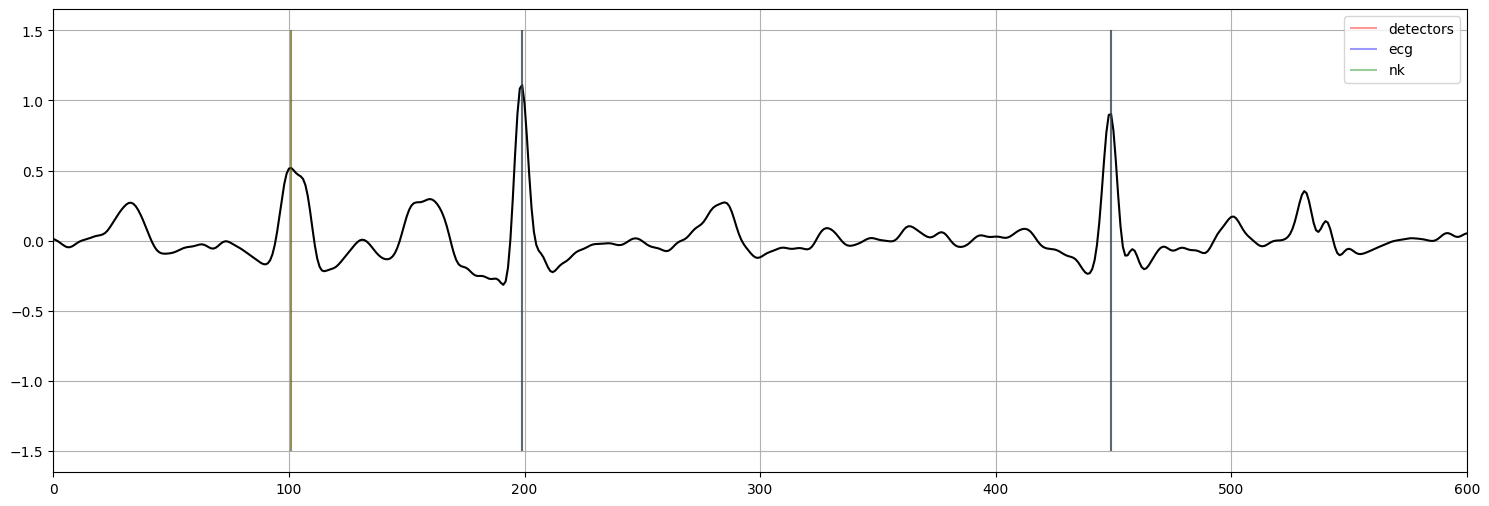

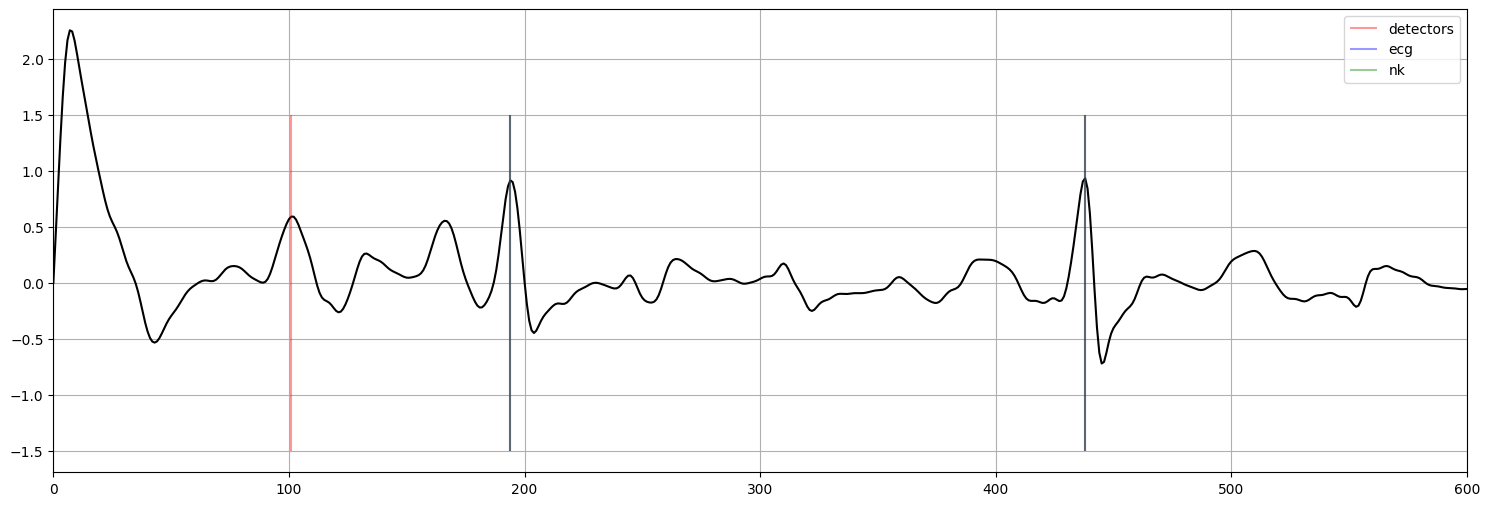

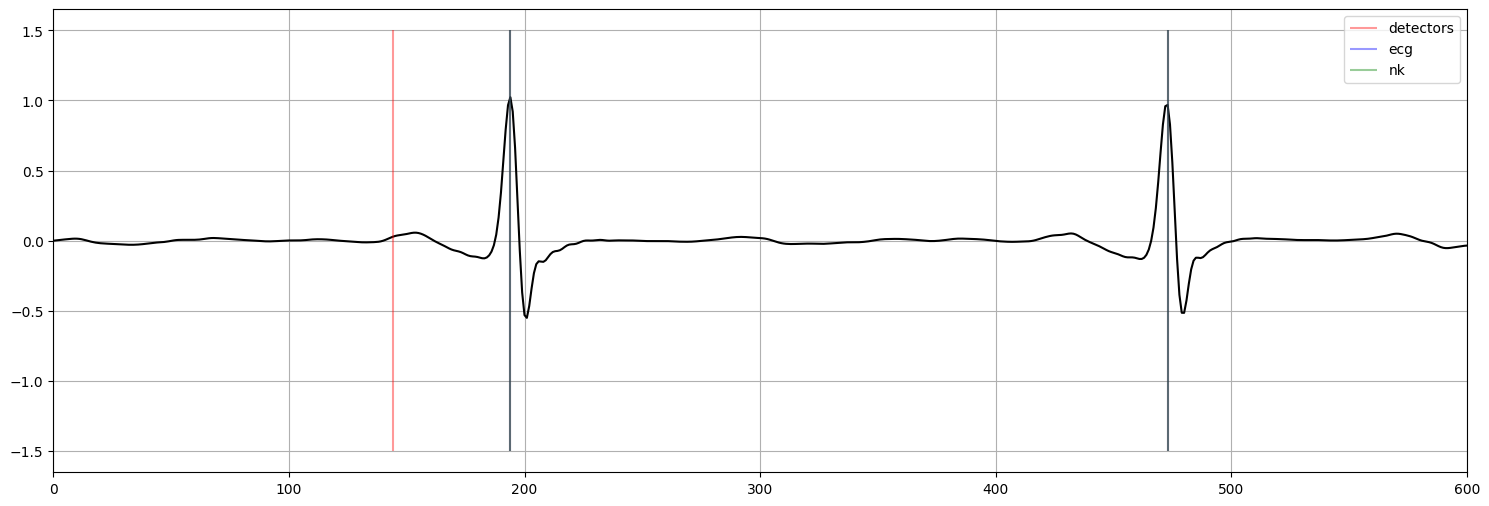

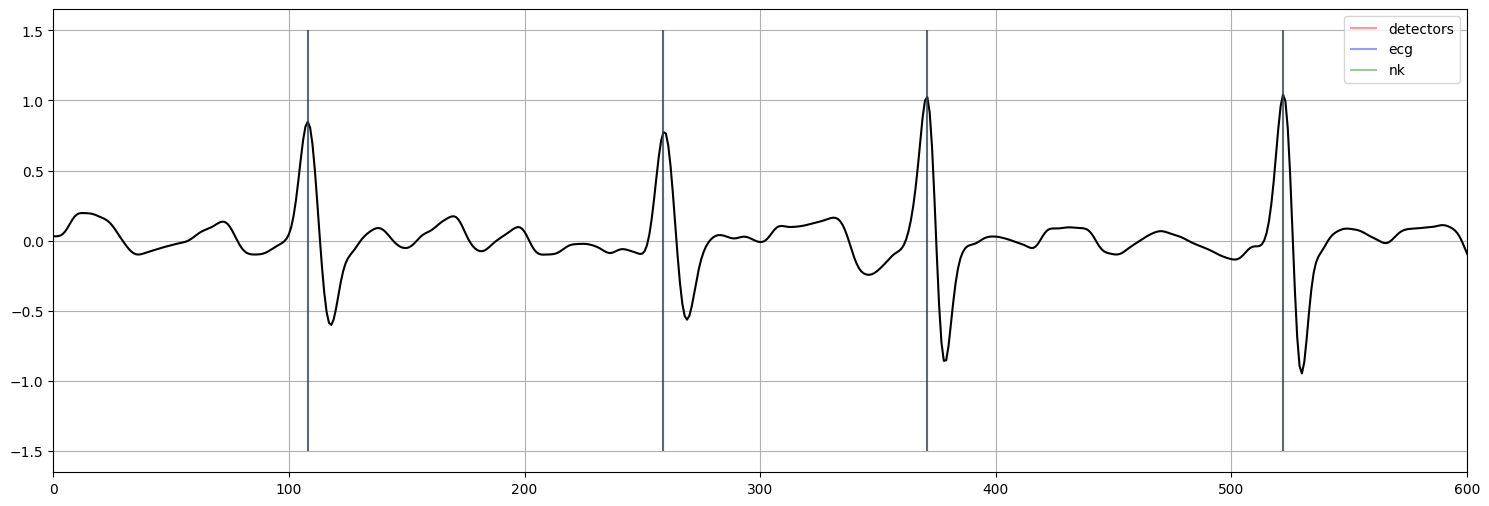

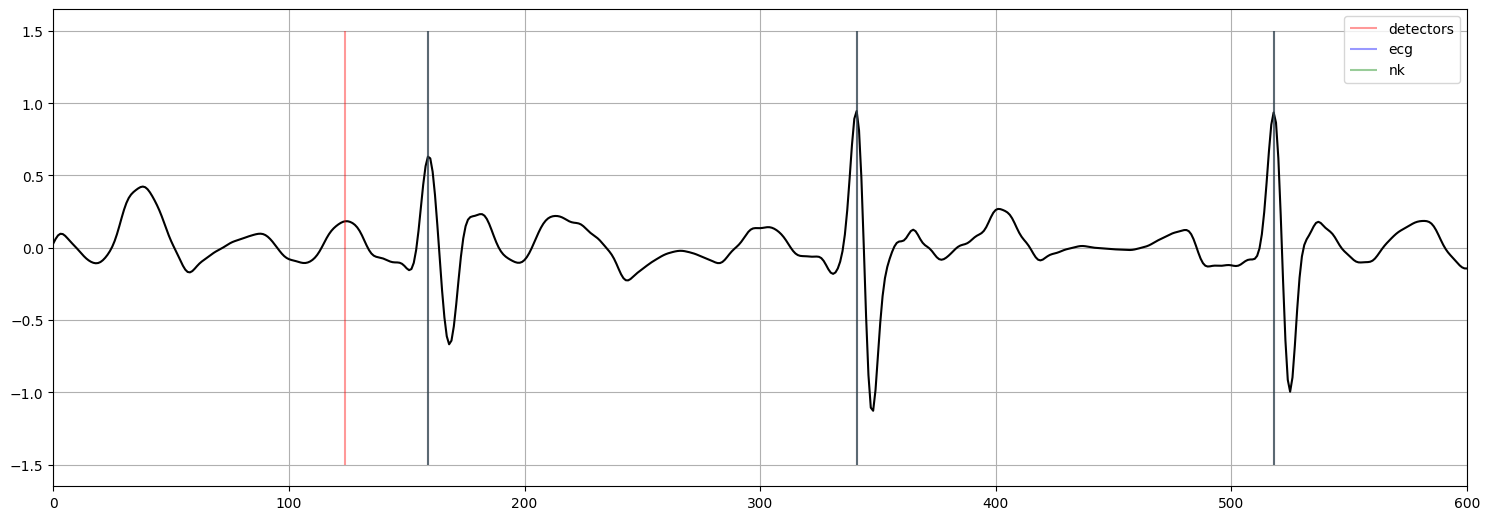

In [45]:
plot_start = 0
plot_finish = plot_start + 600

class_to_show = 2
num_to_show = 5
offset = 264

ind = sample_signal_ids[class_to_show][offset:offset+num_to_show]

for i, j in enumerate(ind):

    processed = X_train_transformed_np[i]
    detectors = Detectors(300)
    rpeaks_detectors = correct_rpeaks(processed, np.asarray(detectors.pan_tompkins_detector(processed)), 300, .15)[0]
    rpeaks_ecg = correct_rpeaks(processed, ecg.engzee_segmenter(processed, 300)['rpeaks'], 300, .15)[0]
    rpeaks_nk = correct_rpeaks(processed, nk.ecg_peaks(processed, sampling_rate=300)[1]['ECG_R_Peaks'], 300, .15)[0]

    plt.figure(figsize=(15, 5*len(ind)))
    
    plt.subplot(len(ind), 1, i+1)
    plt.plot(processed, color='black')
    plt.vlines(rpeaks_detectors, ymin=-1.5, ymax=1.5, colors = ['red'], alpha=.4, label='detectors')
    plt.vlines(rpeaks_ecg, ymin=-1.5, ymax=1.5, colors = ['blue'], alpha=.4, label='ecg')
    plt.vlines(rpeaks_nk, ymin=-1.5, ymax=1.5, colors = ['green'], alpha=.4, label='nk')

    plt.xlim((plot_start, plot_finish))
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
plt.show()

In [36]:
detect_found =[]
ecg_found =[]
nk_found =[]

for i in range(2000):
    detectors = Detectors(300)
    detect_found.append(len(correct_rpeaks(X_train_transformed_np[i], np.asarray(detectors.pan_tompkins_detector(X_train_transformed_np[i])), 300, .15)[0]))
    ecg_found.append(len(correct_rpeaks(X_train_transformed_np[i], ecg.engzee_segmenter(X_train_transformed_np[i], 300)['rpeaks'], 300, .15)[0]))
    nk_found.append(len(correct_rpeaks(X_train_transformed_np[i], nk.ecg_peaks(X_train_transformed_np[i], sampling_rate=300)[1]['ECG_R_Peaks'], 300, .15)[0]))

In [37]:
peaks = pd.DataFrame({'detect': detect_found, 'ecg': ecg_found, 'nk': nk_found})
peaks.describe()

,detect,ecg,nk
count,2000.000000,2000.000000,2000.000000
mean,38.043500,35.489500,37.503500
std,16.689784,16.717525,16.040406
min,1.000000,0.000000,9.000000
25%,29.000000,27.000000,29.000000
50%,34.000000,32.000000,34.000000
75%,42.000000,40.000000,41.000000
max,145.000000,145.000000,145.000000


<Axes: >

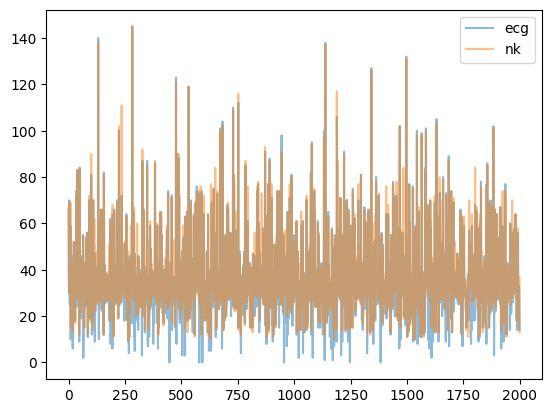

In [66]:
peaks.plot(y=['ecg', 'nk'], alpha=.5)

<Axes: ylabel='Frequency'>

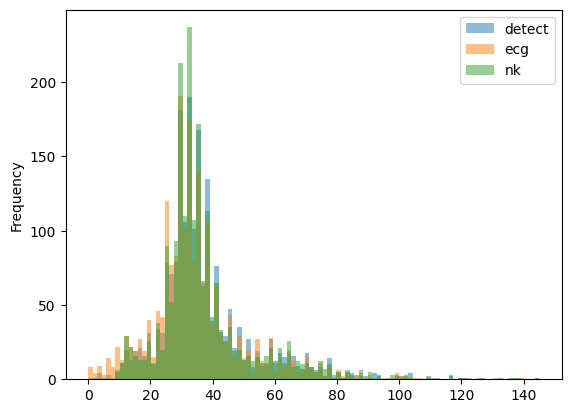

In [64]:
peaks.plot.hist(bins=100, alpha=.5)

In [75]:
index = np.argmin(detect_found)
index

429

In [77]:
detect_found[index]

1

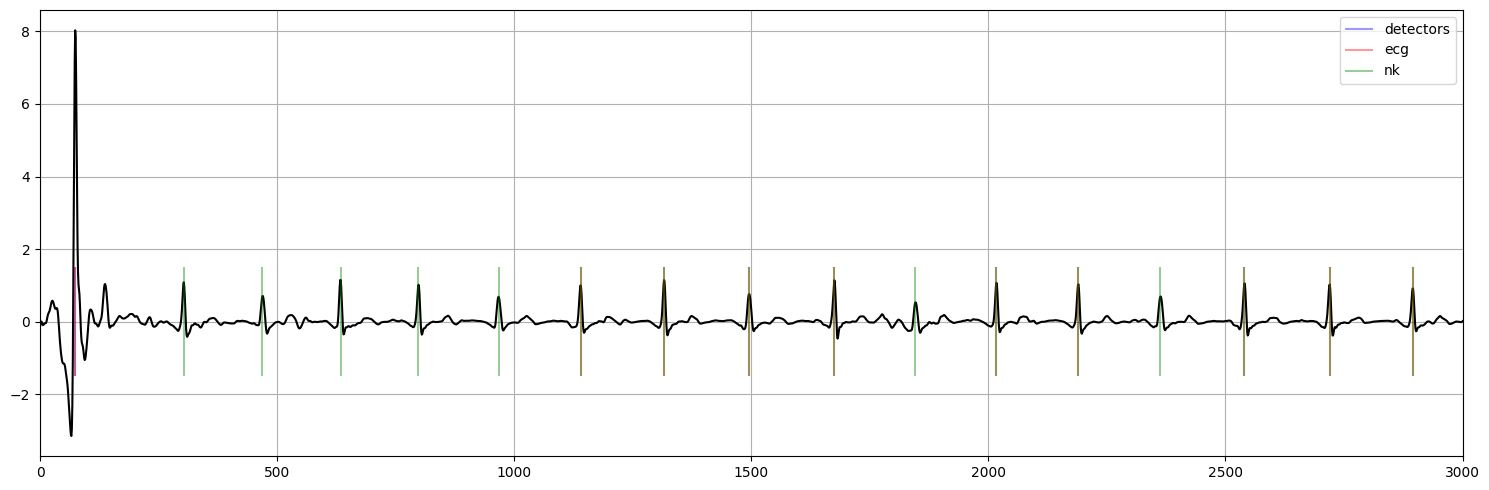

In [79]:
i = index

processed = X_train_transformed_np[i]
detectors = Detectors(300)
rpeaks_detectors = correct_rpeaks(processed, np.asarray(detectors.pan_tompkins_detector(processed)), 300, .15)[0]
rpeaks_ecg = correct_rpeaks(processed, ecg.engzee_segmenter(processed, 300)['rpeaks'], 300, .15)[0]
rpeaks_nk = correct_rpeaks(processed, nk.ecg_peaks(processed, sampling_rate=300)[1]['ECG_R_Peaks'], 300, .15)[0]

plt.figure(figsize=(15, 5))

plt.plot(processed, color='black')
plt.vlines(rpeaks_detectors, ymin=-1.5, ymax=1.5, colors = ['blue'], alpha=.4, label='detectors')
plt.vlines(rpeaks_ecg, ymin=-1.5, ymax=1.5, colors = ['red'], alpha=.4, label='ecg')
plt.vlines(rpeaks_nk, ymin=-1.5, ymax=1.5, colors = ['green'], alpha=.4, label='nk')

plt.xlim((0, 3000))
plt.legend()
plt.grid()
plt.tight_layout()

In [ ]:
index = sample_signal_ids[0][0]
lll = 18000
# nk.ecg_process(X_train_extended_np[index], sampling_rate=300)[0].iloc[:1200].plot(y=['ECG_Raw', 'ECG_Clean'], figsize=(21,7))
(nk.ecg_process(X_train_extended_np[index], sampling_rate=300)[0].iloc[:lll] * 100).plot(y=['ECG_Quality'], figsize=(21,7))
plt.plot(X_train_transformed_np[index,:lll]*200)
plt.xlim((10000,14000))

# OBTAIN TEST DATA

In [17]:
X_test  = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')
X_test_np = X_test.to_numpy()

X_test_transformed_np = np.array([process_signal(row) for row in X_test_np])
X_test_transformed = pd.DataFrame(data=X_test_transformed_np, columns=X_test.columns, index=X_test.index)

X_test_downsampled_np = X_test_transformed_np[:,::2]
X_test_downsampled = pd.DataFrame(X_test_downsampled_np)

X_test_reduced = reduce_signal(X_test_downsampled)
X_test_reduced_np = X_test_reduced.to_numpy()

# X_test_downsampled_np = np.apply_along_axis(lambda x: np.interp(np.linspace(0, x.size, length), range(x.size), x),
#                                              1,
#                                              X_test_transformed_np)

In [18]:
X_train_reduced_np.shape, X_test_reduced_np.shape

((122081, 1200), (3411, 1200))

# MODEL TRAINING

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential, Model
from tensorflow.keras.layers import ELU, LSTM, GRU, Dense, Input, concatenate, MaxPool2D, BatchNormalization, Dropout, Conv1D, Flatten, MaxPooling1D, Conv2D, Input, Concatenate, GlobalAveragePooling1D, Activation
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

In [20]:
# Convert labels to categorical
y_train_cat_np = to_categorical(y_train_extended.to_numpy())

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_reduced_np, y_train_cat_np, test_size=0.2, random_state=23)

In [21]:
learning_rate = 5e-3
dropout = 0.5
dropout_CNN = .5
recurrent_dropout = 0.0

In [22]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_partial.shape[1],1)))
model.add(BatchNormalization())
model.add(Dropout(dropout_CNN))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=7, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_CNN))
model.add(Conv1D(filters=128, kernel_size=11, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=13, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_CNN))
model.add(Conv1D(filters=128, kernel_size=15, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=4, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],#, AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.RMSprop())
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0, 
                             factor=0.5,
                             min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=1500,
                           verbose=1,
                           mode='auto',
                           baseline=0,
                           restore_best_weights=True)

2023-12-01 12:11:05.110579: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-12-01 12:11:05.110597: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-12-01 12:11:05.110601: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-12-01 12:11:05.110651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-01 12:11:05.110865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1198, 64)          256       
                                                                 
 batch_normalization (Batch  (None, 1198, 64)          256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1198, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1194, 128)         41088     
                                                                 
 batch_normalization_1 (Bat  (None, 1194, 128)         512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1194, 128)         0

In [23]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-6)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=20,
                           verbose=1,
                           mode='max',
                           baseline=0.75,
                           start_from_epoch=1,
                           restore_best_weights=True)

In [24]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=1500,
                    batch_size=2048,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/1500


2023-12-01 12:11:06.608220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 94s 2s/step - loss: 1.8012 - accuracy: 0.2494 - val_loss: 1.4453 - val_accuracy: 0.2502
Epoch 2/1500
48/48 [==============================] - 62s 1s/step - loss: 1.5111 - accuracy: 0.2530 - val_loss: 1.5570 - val_accuracy: 0.2502
Epoch 3/1500
48/48 [==============================] - 62s 1s/step - loss: 1.4562 - accuracy: 0.2562 - val_loss: 1.6275 - val_accuracy: 0.2493
Epoch 4/1500
48/48 [==============================] - 62s 1s/step - loss: 1.4294 - accuracy: 0.2612 - val_loss: 3.6220 - val_accuracy: 0.2493
Epoch 5/1500
48/48 [==============================] - 61s 1s/step - loss: 1.4201 - accuracy: 0.2609 - val_loss: 3.4340 - val_accuracy: 0.2493
Epoch 6/1500
48/48 [==============================] - 59s 1s/step - loss: 1.4139 - accuracy: 0.2613 - val_loss: 6.6978 - val_accuracy: 0.2493
Epoch 7/1500
48/48 [==============================] - 59s 1s/step - loss: 1.4006 - accuracy: 0.2610 - val_loss: 2.5512 - val_accuracy: 0.2494
Epoch 8/1500
48/48 

2/2 [==============================] - 0s 182ms/step - loss: 3.5611 - accuracy: 0.3815
-----------------------------------------------------------------
train accuracy = 39.6552%
test accuracy = 38.1466%


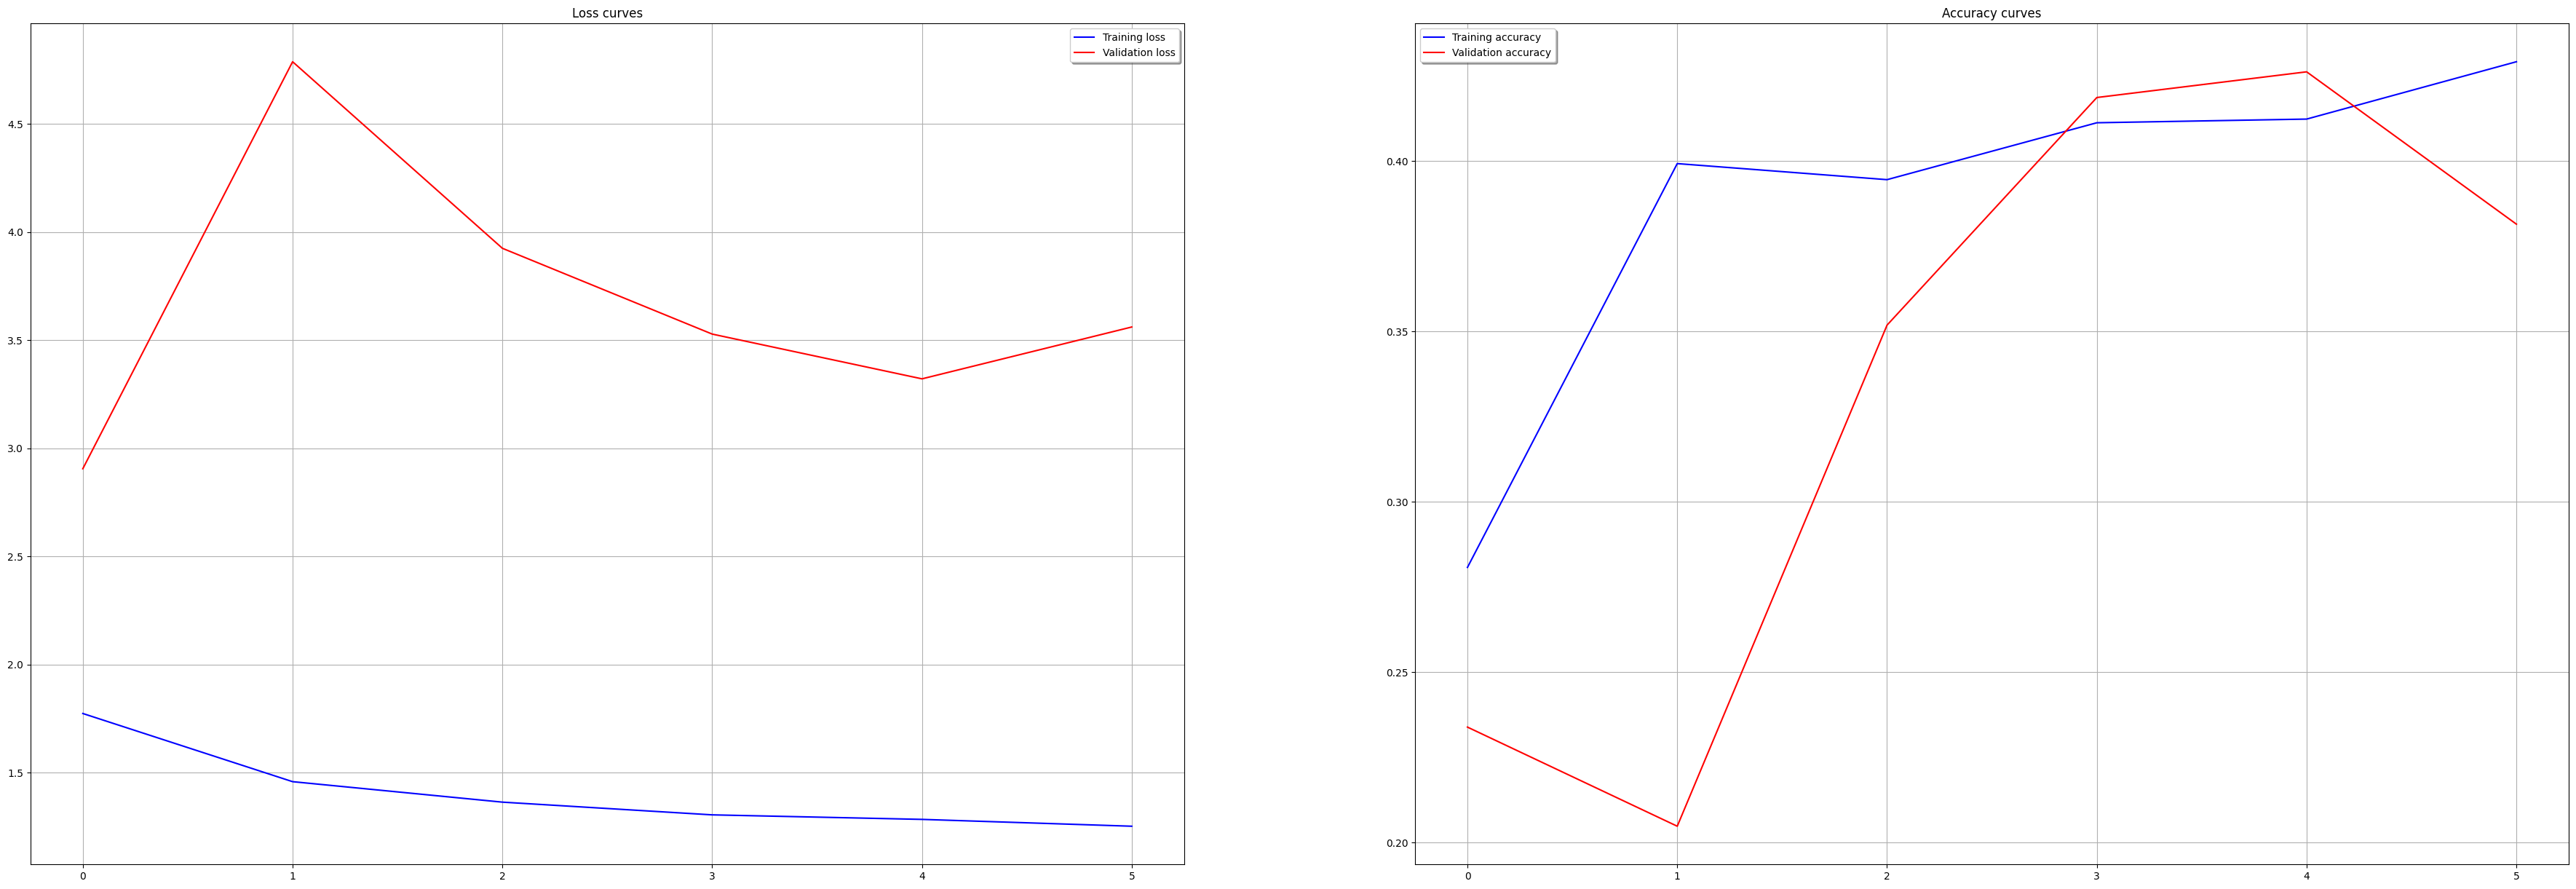

58/58 [==============================] - 1s 8ms/step
0.38146551724137934


In [ ]:
model.save("model_dunno.keras")

train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=1024,
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                        y_val,
                                        batch_size=1024,
                                        verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [ ]:
y_test_pred_np = model.predict(X_test_reduced_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_dunno.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 1s 7ms/step


In [ ]:
hbhbhbbh

In [ ]:
T=X_train_partial.shape[1]

In [ ]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(T,1)))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=13, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=15, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=48, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=48, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=4, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],#, AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=.001))
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_151 (Conv1D)         (None, 1998, 32)          128       
                                                                 
 dropout_124 (Dropout)       (None, 1998, 32)          0         
                                                                 
 max_pooling1d_85 (MaxPooli  (None, 999, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_152 (Conv1D)         (None, 995, 64)           10304     
                                                                 
 dropout_125 (Dropout)       (None, 995, 64)           0         
                                                                 
 max_pooling1d_86 (MaxPooli  (None, 497, 64)           0         
 ng1D)                                               

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=5000,
                    batch_size=256,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/5000
38/38 [==============================] - 10s 201ms/step - loss: 1.5988 - accuracy: 0.3363 - val_loss: 1.2577 - val_accuracy: 0.4353
Epoch 2/5000
38/38 [==============================] - 3s 76ms/step - loss: 1.3712 - accuracy: 0.3834 - val_loss: 2.1770 - val_accuracy: 0.2459
Epoch 3/5000
38/38 [==============================] - 2s 51ms/step - loss: 1.3399 - accuracy: 0.3967 - val_loss: 2.6539 - val_accuracy: 0.2545
Epoch 4/5000
38/38 [==============================] - 2s 57ms/step - loss: 1.3314 - accuracy: 0.4000 - val_loss: 2.7004 - val_accuracy: 0.2549
Epoch 5/5000
38/38 [==============================] - 2s 51ms/step - loss: 1.2909 - accuracy: 0.4101 - val_loss: 2.4094 - val_accuracy: 0.2549
Epoch 6/5000
38/38 [==============================] - 2s 54ms/step - loss: 1.2124 - accuracy: 0.4404 - val_loss: 1.9976 - val_accuracy: 0.2545
Epoch 7/5000
38/38 [==============================] - 2s 53ms/step - loss: 1.1758 - accuracy: 0.4488 - val_loss: 1.8618 - val_accuracy: 0.25

3/3 [==============================] - 0s 110ms/step - loss: 3.2853 - accuracy: 0.2549
-----------------------------------------------------------------
train accuracy = 24.9511%
test accuracy = 25.4942%


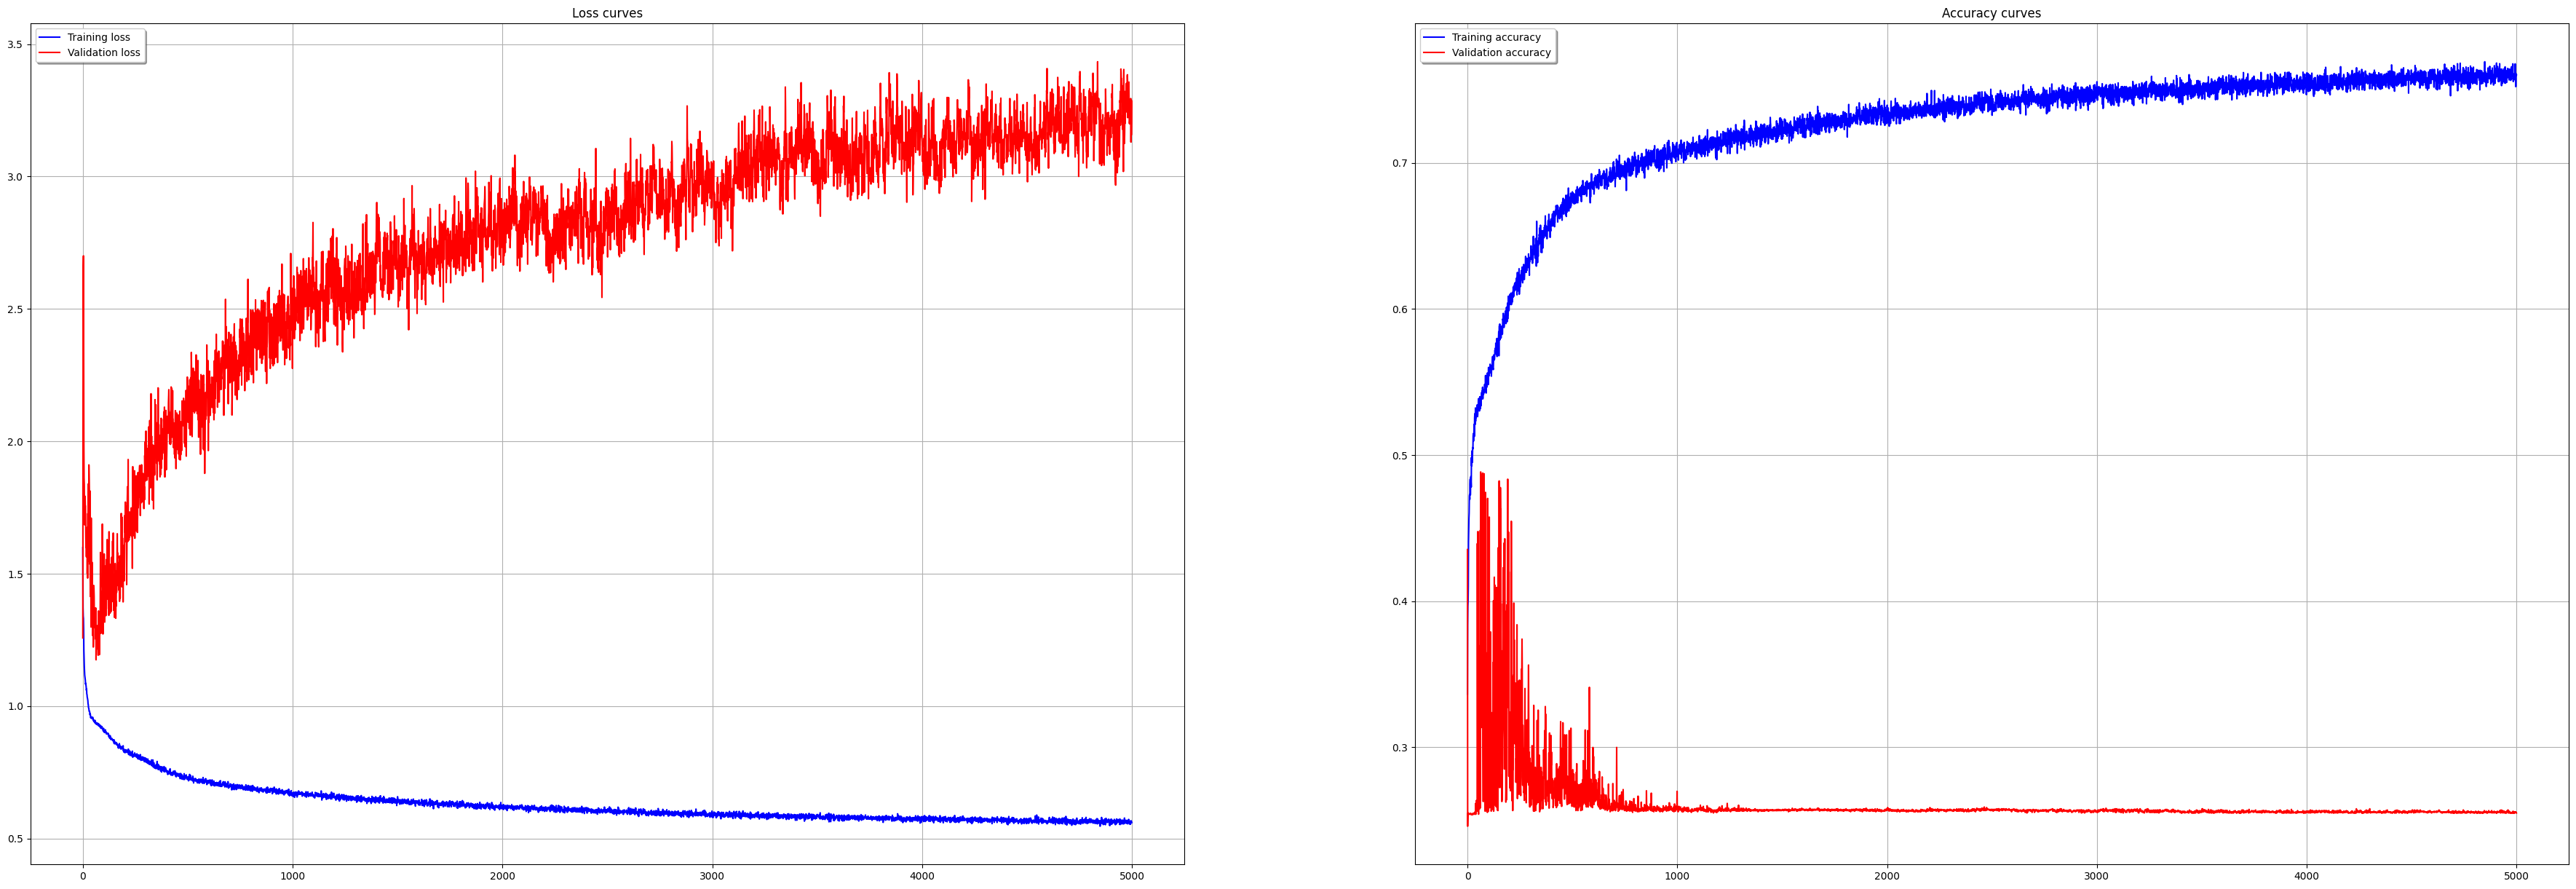

76/76 [==============================] - 1s 10ms/step
0.2549423393739704


In [ ]:
model.save("model_dunno.keras")


train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=1024,
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                        y_val,
                                        batch_size=1024,
                                        verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [ ]:
y_pred = model.predict(X_te)

y_pred_class_np = y_pred.argmax(axis=1)

InvalidArgumentError: Graph execution error:

Detected at node sequential_30/batch_normalization_146/batchnorm/mul_1 defined at (most recent call last):
  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/n2/rfc_8wbn4n5bqd9_rm70nslh0000gn/T/ipykernel_59174/1976090744.py", line 1, in <module>

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 788, in call

Incompatible shapes: [2432] vs. [32,34048]
	 [[{{node sequential_30/batch_normalization_146/batchnorm/mul_1}}]] [Op:__inference_predict_function_1337367]

In [ ]:
y_test_pred_np = model.predict(X_test_downsampled_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_dunno.csv', columns=['id', 'y'], index = False)